In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,f1_score,roc_auc_score,recall_score
from imblearn.over_sampling import SMOTE



In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:

data = pd.read_csv('spam_ham_output_imbalance.csv')  
print(data.head())

print(data.shape)

data['Category'].value_counts()



  Category                                            Message
0     spam  From 12a1mailbot1@web.de  Thu Aug 22 13:17:22 ...
1     spam  From ilug-admin@linux.ie  Thu Aug 22 13:27:39 ...
2     spam  From sabrina@mx3.1premio.com  Thu Aug 22 14:44...
3     spam  From wsup@playful.com  Thu Aug 22 16:17:00 200...
4     spam  From social-admin@linux.ie  Thu Aug 22 16:37:3...
(19601, 2)


Category
ham     12730
spam     6837
Name: count, dtype: int64

In [4]:
def preprocess_text(Message):
    if not isinstance(Message, str):
        return ""
    Message = Message.lower()
    Message = re.sub(r'[^a-zA-Z0-9\s]', '', Message)
    words = Message.split()
    words = [w for w in words if w not in stopwords.words('english')]
    return ' '.join(words)

print("Data preprocessing function::")

Data preprocessing function::


In [5]:
z = data['Message'].apply(preprocess_text)
y = data['Category'].apply(lambda x:1 if x=='ham' else 0)

print(data['Message'].apply(type).value_counts())
print(data['Message'].isna().sum())

print(data.head())

data['Category'].value_counts()


Message
<class 'str'>      19568
<class 'float'>       33
Name: count, dtype: int64
33
  Category                                            Message
0     spam  From 12a1mailbot1@web.de  Thu Aug 22 13:17:22 ...
1     spam  From ilug-admin@linux.ie  Thu Aug 22 13:27:39 ...
2     spam  From sabrina@mx3.1premio.com  Thu Aug 22 14:44...
3     spam  From wsup@playful.com  Thu Aug 22 16:17:00 200...
4     spam  From social-admin@linux.ie  Thu Aug 22 16:37:3...


Category
ham     12730
spam     6837
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(z, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
# Vectorize the training data
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)


In [8]:
# from sklearn.decomposition import TruncatedSVD
# from collections import Counter

# # 
# svd = TruncatedSVD(n_components=200, random_state=42) 
# X_reduced = svd.fit_transform(x)

# print("Before SMOTE:", Counter(y))



In [9]:

# smote = SMOTE(random_state=42)
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train)

# print("After SMOTE:", Counter(y_train_balanced))


C:\Users\hari\AppData\Local\Temp\ipykernel_5332\1106235751.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette="viridis")


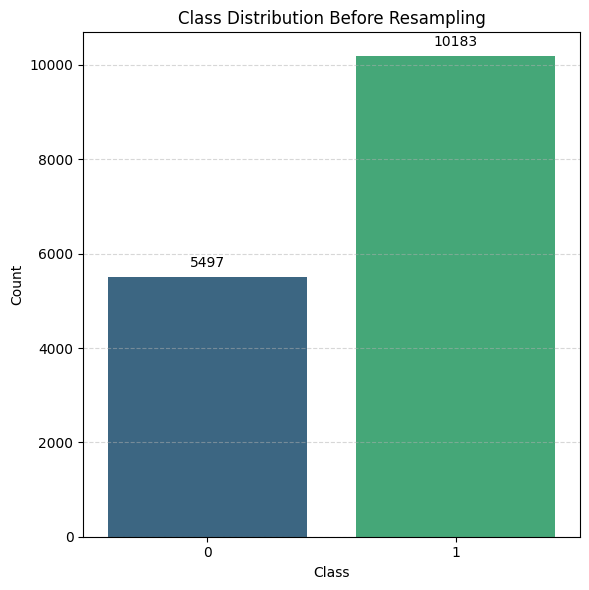

C:\Users\hari\AppData\Local\Temp\ipykernel_5332\1106235751.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette="viridis")


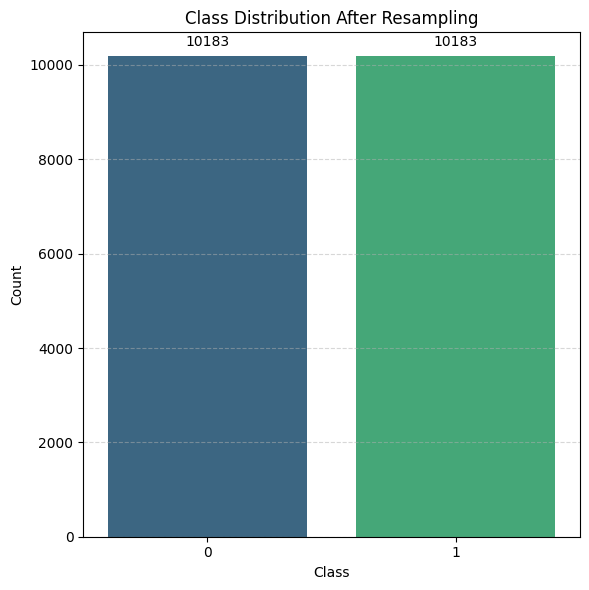

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(y, title):
    plt.figure(figsize=(6,6))
    ax = sns.countplot(x=y, palette="viridis")
    
    # Add count labels on bars
    for p in ax.patches:
        count = int(p.get_height())
        ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Before SMOTE
plot_class_distribution(y_train, "Class Distribution Before Resampling")

# After SMOTE
plot_class_distribution(y_train_balanced, "Class Distribution After Resampling")


In [11]:
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier()),
    ('ada', AdaBoostClassifier())
]

from collections import Counter

print("Before SMOTE:", Counter(y_test))



Before SMOTE: Counter({1: 2547, 0: 1374})


In [12]:
meta_model = LogisticRegression()

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True
)
print(f"{stacking_clf}")

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('dt', DecisionTreeClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('ada', AdaBoostClassifier())],
                   final_estimator=LogisticRegression(), passthrough=True)


In [13]:
print("Training the Stacking Classifier...")
stacking_clf.fit(X_train_balanced, y_train_balanced)


Training the Stacking Classifier...


c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('dt', DecisionTreeClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('ada', AdaBoostClassifier())],
                   final_estimator=LogisticRegression(), passthrough=True)

In [14]:
y_pred = stacking_clf.predict(X_test_vec)
y_prob = stacking_clf.predict_proba(X_test_vec)[:,1]


print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1374
           1       1.00      1.00      1.00      2547

    accuracy                           0.99      3921
   macro avg       0.99      0.99      0.99      3921
weighted avg       0.99      0.99      0.99      3921




Confusion Matrix:
 [[1365    9]
 [  11 2536]]
 FNR: 0.0043, FPR: 0.0066



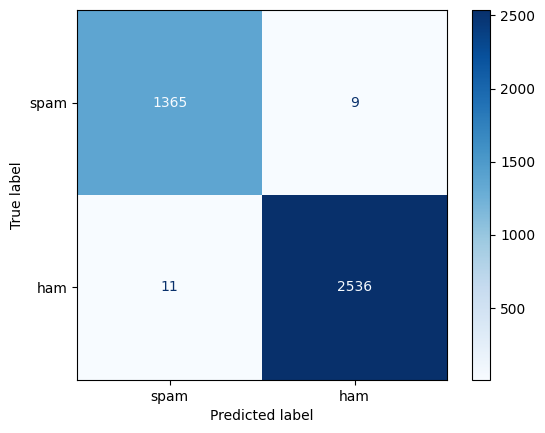

In [15]:
cm = confusion_matrix(y_test,y_pred)
print("\nConfusion Matrix:\n",cm)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["spam", "ham"],cmap='Blues', values_format='d')
print(disp)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fnr = fn / (fn + tp) if (fn + tp) else 0
fpr = fp / (fp + tn) if (fp + tn) else 0
    
print(f" FNR: {fnr:.4f}, FPR: {fpr:.4f}\n")



In [16]:
accuracy =accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 =f1_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test,y_prob)

print(f"\nAccuracy:{accuracy:.4f}")
print(f"precision:{precision:.4f}")
print(f"Recall:{recall:.4f}")
print(f"F1 Score:{f1:.4f}")
print(f"ROC Auc: {roc_auc:.4f}")


Accuracy:0.9949
precision:0.9965
Recall:0.9957
F1 Score:0.9961
ROC Auc: 0.9992


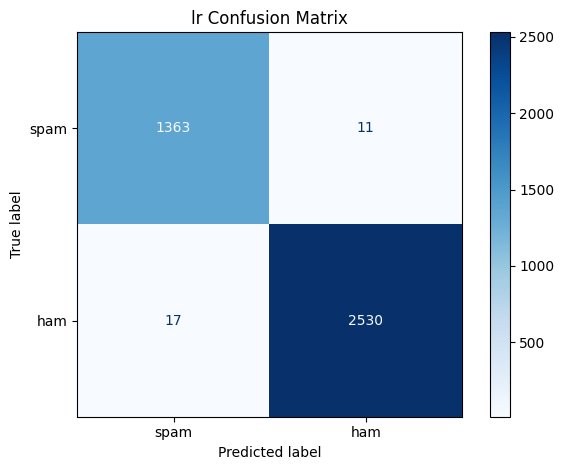

lr → FNR: 0.0067, FPR: 0.0080



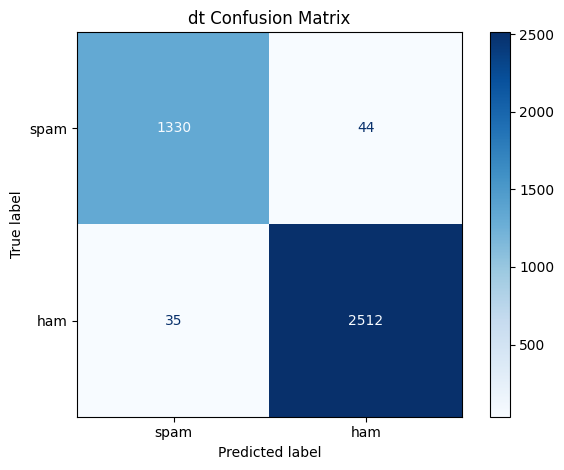

dt → FNR: 0.0137, FPR: 0.0320



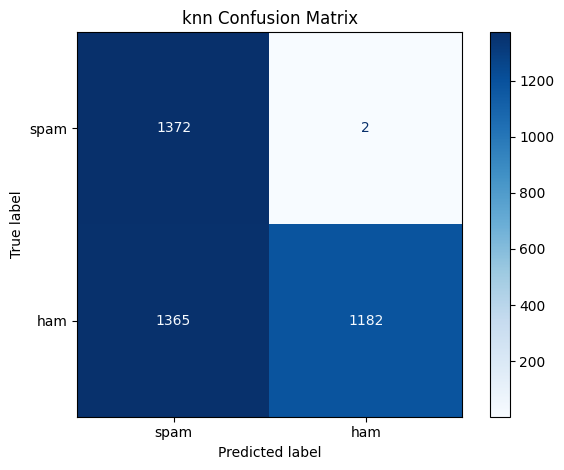

knn → FNR: 0.5359, FPR: 0.0015



c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


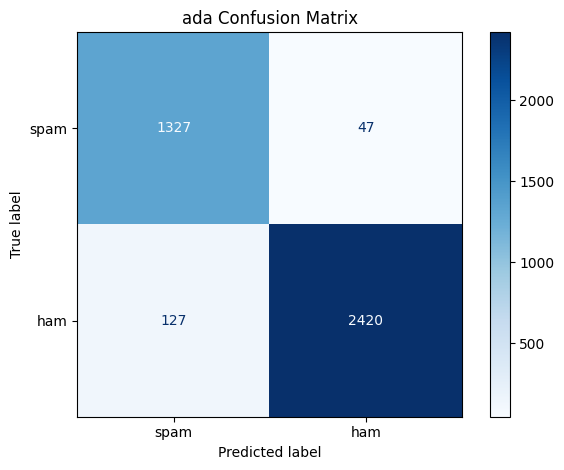

ada → FNR: 0.0499, FPR: 0.0342



In [17]:
for name, model in base_models:
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["spam", "ham"],cmap='Blues', values_format='d')
    disp.ax_.set_title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0
    
    print(f"{name} → FNR: {fnr:.4f}, FPR: {fpr:.4f}\n")



In [18]:
print("\n--- Base Model Evaluations ---\n")

for name, model in base_models:
    print(f"\nEvaluating {name.upper()}...")
    
    # Train the model
    model.fit(X_train_vec, y_train)
    
    # Predict
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc}")



--- Base Model Evaluations ---


Evaluating LR...
Accuracy:  0.9929
Precision: 0.9957
Recall:    0.9933
F1 Score:  0.9945
ROC AUC:   0.9982049264225571

Evaluating DT...
Accuracy:  0.9776
Precision: 0.9812
Recall:    0.9843
F1 Score:  0.9828
ROC AUC:   0.9746803757481617

Evaluating KNN...
Accuracy:  0.6514
Precision: 0.9983
Recall:    0.4641
F1 Score:  0.6336
ROC AUC:   0.9240765600881021

Evaluating ADA...


c:\Users\hari\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.9556
Precision: 0.9809
Recall:    0.9501
F1 Score:  0.9653
ROC AUC:   0.9902401089502793
